# Análisis de Imágenes Biomédicas. Práctica 1
## Máster en Bioinformática para las Ciencias de la Salud
### Pedro Sánchez García

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import cv2
import skimage
from skimage import measure

# METODOLOGÍA.

## 1. Determinación del espacio de color y canal o canales que proporcionan más información.

#### Progresivamente, se analizan estas cuestiones para las imágenes del dataset. Partiendo de que nuestro interés es la mejor detección de los vasos, la finalidad es tomar una decisión acerca del espacio de color y canal con el que se llevarán a cabo los siguientes procesos de la metodología planteada.

### Ejemplo para BN_12_2.5.BMP:

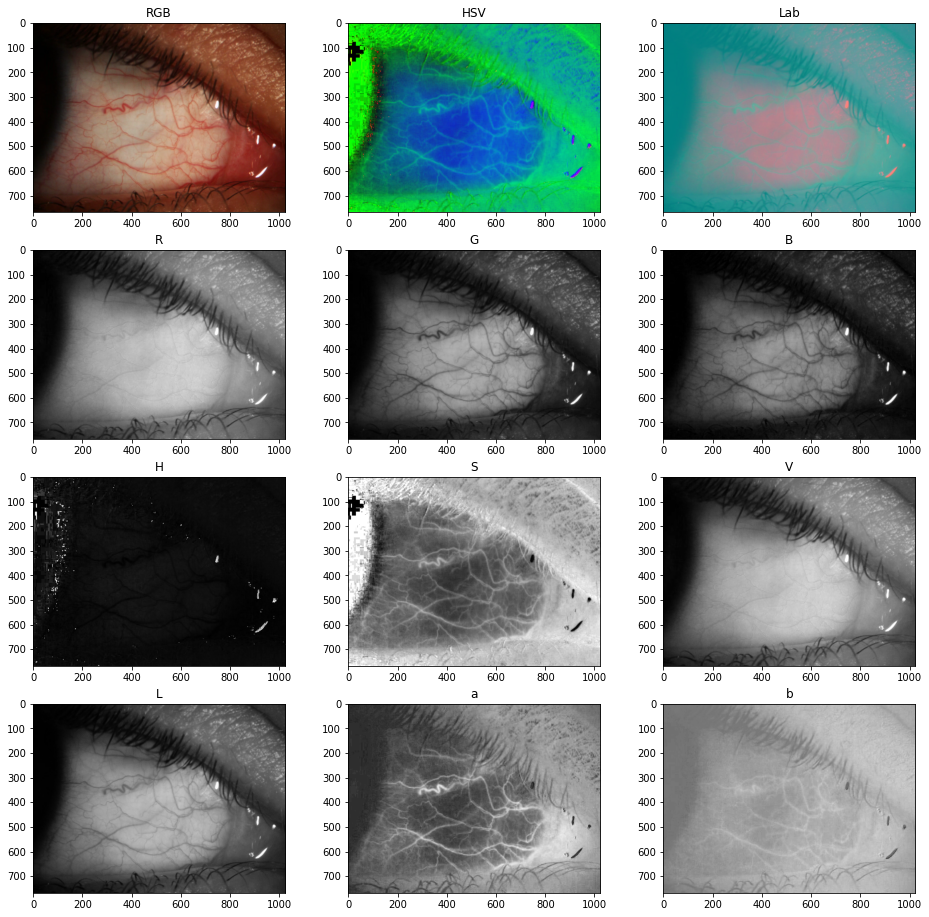

In [3]:
# Carga de las imagenes originales que se desean analizar procedente del dataset:
# BN_12_2.5.BMP, BN_15_1.BMP, BN_19_1.BMP, BN_024_1.1.jpg, BN_056_3.jpg, BN_058_2.jpg, BT_03_1.BMP, BT_04_1.BMP, BT_12_2.5.BMP, BT_13_2.BMP

im_12_25o = cv2.imread('dataset/BN_12_2.5.BMP')
im_15_1o = cv2.imread('dataset/BN_15_1.BMP')
im_19_1o = cv2.imread('dataset/BN_19_1.BMP')
im_024_1o = cv2.imread('dataset/BN_024_1.1.jpg')
im_056_3o = cv2.imread('dataset/BN_056_3.jpg')
im_058_2o = cv2.imread('dataset/BN_058_2.jpg')
im_03_1o = cv2.imread('dataset/BT_03_1.BMP')
im_04_1o = cv2.imread('dataset/BT_04_1.BMP')
im_t12_25o = cv2.imread('dataset/BT_12_2.5.BMP')
im_13_2o = cv2.imread('dataset/BT_13_2.BMP')


# Conversiones a los espacios de color RGB, HSV y Lab. En este caso, las conversiones se efectúan sobre la imagen im_12_25:
im_12_25_rgb = cv2.cvtColor(im_12_25o, cv2.COLOR_BGR2RGB) 
im_12_25_hsv = cv2.cvtColor(im_12_25o, cv2.COLOR_BGR2HSV) 
im_12_25_Lab = cv2.cvtColor(im_12_25o, cv2.COLOR_BGR2Lab)

# Muestra de espacios y canales correspondientes a la imagen im_12_25 analizada:
plt.rcParams["figure.figsize"] = [16,16]
f, ax = plt.subplots(4,3)
ax[0,0].imshow(im_12_25_rgb)
ax[0,0].set_title('RGB')
ax[0,1].imshow(im_12_25_hsv)
ax[0,1].set_title('HSV')
ax[0,2].imshow(im_12_25_Lab)
ax[0,2].set_title('Lab')
ax[1,0].imshow(im_12_25_rgb[:,:,0], cmap='gray')
ax[1,0].set_title('R')
ax[1,1].imshow(im_12_25_rgb[:,:,1], cmap='gray')
ax[1,1].set_title('G')
ax[1,2].imshow(im_12_25_rgb[:,:,2], cmap='gray')
ax[1,2].set_title('B')
ax[2,0].imshow(im_12_25_hsv[:,:,0], cmap='gray')
ax[2,0].set_title('H')
ax[2,1].imshow(im_12_25_hsv[:,:,1], cmap='gray')
ax[2,1].set_title('S')
ax[2,2].imshow(im_12_25_hsv[:,:,2], cmap='gray')
ax[2,2].set_title('V')
ax[3,0].imshow(im_12_25_Lab[:,:,0], cmap='gray')
ax[3,0].set_title('L')
ax[3,1].imshow(im_12_25_Lab[:,:,1], cmap='gray')
ax[3,1].set_title('a')
ax[3,2].imshow(im_12_25_Lab[:,:,2], cmap='gray')
ax[3,2].set_title('b')
plt.show()

#### En general, para las imágenes proporcionadas, se puede apreciar que el espacio de color RGB es el que proporciona una mayor información en lo que a detección de vasos se refiere. En concreto, el canal G es el que ofrece un mejor contraste entre los vasos y el fondo. 

#### De esta forma, se trabajará con este canal del espacio RGB para la detección de vasos. No obstante, dado que se evaluó en una primera aproximación, la extracción de la región de interés, se almacenan los canales R y G en los siguientes objetos:

In [4]:
# Extracción de los canales R y G en la imagen para la realización de los siguientes procesos:

im_12_25_r = im_12_25_rgb[:,:,0]
im_12_25_v = im_12_25_rgb[:,:,1]

## 2. Extracción de la región de interés.

#### El proceso de extracción de la región de interés se realiza tratando de mantener la rigurosidad y aproximándose de forma adecuada. Cabe destacar que se persigue el análisis en la conjuntiva bulbar, de tal forma que la pupila y pestañas conforman una información irrelevante. Por tanto, para la presente práctica se ha optado por llevar a cabo las siguientes fases:
#### 2.1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido. 
#### 2.2. Uso de una función del paquete scikit-image para seleccionar el área más grande sobre la imagen de la etapa anterior.

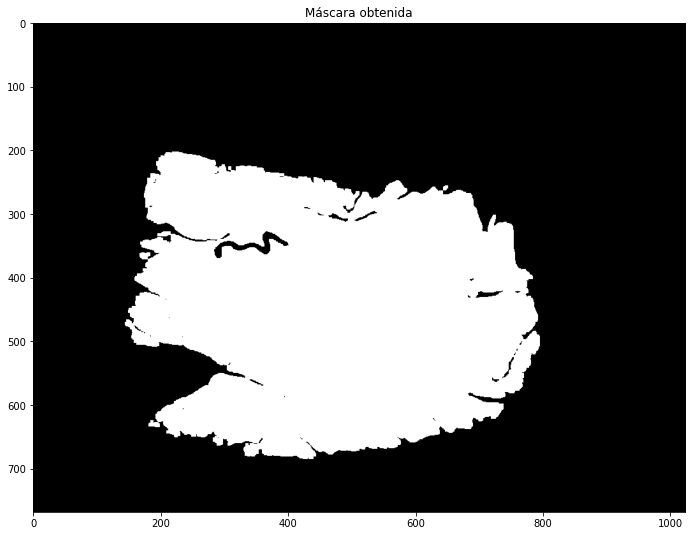

In [5]:
plt.rcParams["figure.figsize"] = [12,9]

# 2.1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido:
thr_12_25, dstOTSU_12_25 = cv2.threshold(im_12_25_v,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
thr, dst31 = cv2.threshold(dstOTSU_12_25, 100, 255, cv2.THRESH_TOZERO) 
dst3_12_25 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))

# 2.2. Extracción del mayor área en la imagen resultante de la etapa anterior con scikit-image:
labels_mask = measure.label(dst3_12_25)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask_12_25 = labels_mask

# Visualización de la máscara obtenida:
plt.imshow(mask_12_25, cmap='gray')
plt.title('Máscara obtenida')
plt.show()

## 3. Segmentación de los vasos.

#### 3.1 Suavizado con filtro de medianas (tamaño 7) sobre el canal G separado en la etapa inicial.
#### 3.2 Umbralización adaptativa para una adecuada segmentación y tratamiento de diferente luminosidad. 
#### 3.3 Aplicación de bottom hat para el posterior cálculo de métrica. 
#### 3.4 Determinación de la región final de interés mediante el producto de la máscara obtenida anteriormente y la imagen resultante de bottom hat. 

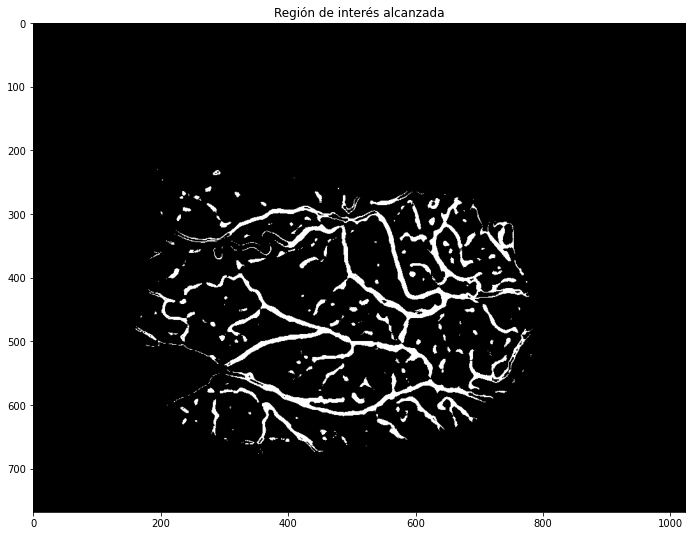

In [6]:
# 3.1 Filtro de medianas sobre canal G con tamaño 7:
median = cv2.medianBlur(im_12_25_v, 7)

# 3.2 Aplicación de umbralización adaptativa en canal G para la segmentación y tratar la diferente luminosidad en las imágenes:
adaptThr = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 3.3 Aplicación de bottom hat de cara a la toma de la métrica:
kernel = np.ones((15,15), np.uint8)
bottom = cv2.morphologyEx(adaptThr, cv2.MORPH_BLACKHAT, kernel)

# 3.4 Producto del resultado de umbralización adaptativa por el de la máscara generada:
región_final_12_25 = bottom * mask_12_25

plt.imshow(región_final_12_25, cmap='gray')
plt.title('Región de interés alcanzada')
plt.show()

## 4. Cálculo de la métrica.

#### La última fase de la práctica propuesta consiste en determinar una posible métrica que sirva para establecer una clasificación de la rojez en el ojo. En primer lugar, se lleva a cabo la umbralización adaptativa de la máscara y de la región final que se han obtenido. Posteriormente, para ambas, se hace el sumatorio de aquellos píxeles blancos que están contenidos. 

#### De esta forma, alcanzamos el tamaño total correspondiente a la máscara obtenida, así como el número de píxeles correspondientes a los vasos extraídos en la región final. Con estos datos, se plantea la proporción entre ambos a través del siguiente porcentaje:

##
$$\LARGE
Biomarcador_v =\frac{p}{q}\times {100} 
$$
##

#### donde:
- #### $p$ es el recuento de píxeles blancos en el interior de la región de interés extraída.
- #### $q$ es el recuento de píxeles blancos en la máscara planteada.


In [7]:
# 1.) Se hace umbralización adaptativa sobre la máscara y la región final:

mask_binary = mask_12_25.astype(np.uint8)
región_final = región_final_12_25.astype(np.uint8)

mask_binary = cv2.adaptiveThreshold(mask_binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
región_final_binary = cv2.adaptiveThreshold(región_final, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 2.) Se efectúa el recuento de los píxeles blancos en la máscara y la región de interés alcanzada:
pixeles_blancos = np.sum(región_final == 255)
print(pixeles_blancos)

pixeles_blancos_mask = np.sum(mask_binary == 255)
print(pixeles_blancos_mask)

# 3.) Planteamiento del biomarcador establecido:
métrica_final_12_25 = (pixeles_blancos/ pixeles_blancos_mask)*100
print(métrica_final_12_25)

32285
786432
4.105250040690104


# IMPLEMENTACIÓN DE LA METODOLOGÍA.

## BT_03_1

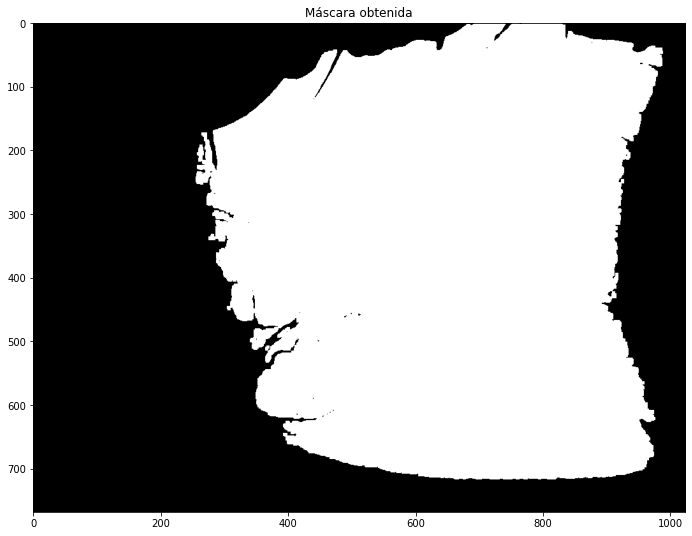

In [8]:
im_03_1_rgb = cv2.cvtColor(im_03_1o, cv2.COLOR_BGR2RGB)

im_03_1_r = im_03_1_rgb[:,:,0]
im_03_1_v = im_03_1_rgb[:,:,1]

plt.rcParams["figure.figsize"] = [12,9] 

# 1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido:
thr, dstOTSU = cv2.threshold(im_03_1_v,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
thr, dst31 = cv2.threshold(dstOTSU, 100, 255, cv2.THRESH_TOZERO) 
dst3_03_1 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))

# 2. Extracción del mayor área en la imagen resultante de la etapa anterior con scikit-image:
labels_mask = measure.label(dst3_03_1)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask_03_1 = labels_mask

# Visualización de la máscara obtenida:
plt.imshow(mask_03_1, cmap='gray')
plt.title('Máscara obtenida')
plt.show()

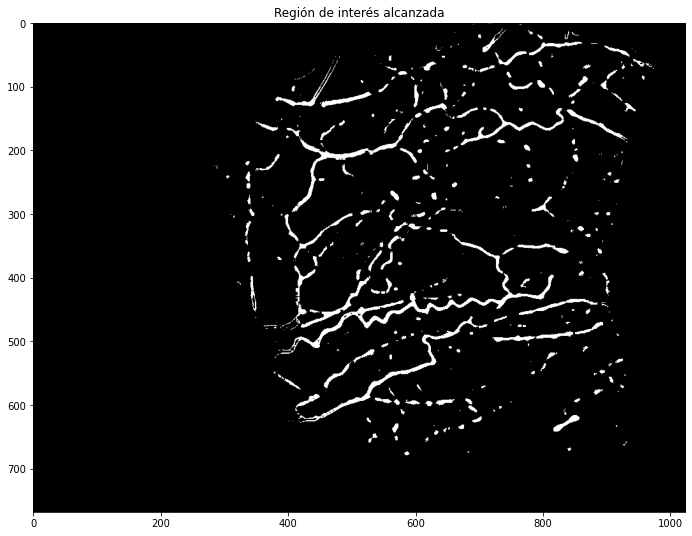

In [9]:
# 3. Filtro de medianas sobre canal G con tamaño 7:
median = cv2.medianBlur(im_03_1_v, 7)

# 4. Aplicación de umbralización adaptativa en canal G para la segmentación y tratar la diferente luminosidad en las imágenes:
adaptThr = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 5. Aplicación de bottom hat de cara a la toma de la métrica:
kernel = np.ones((15,15), np.uint8)        
bottom = cv2.morphologyEx(adaptThr, cv2.MORPH_BLACKHAT, kernel)

# 6. Producto del resultado de umbralización adaptativa por el de la máscara generada:
región_final_03_1 = bottom * mask_03_1

plt.imshow(región_final_03_1, cmap='gray')
plt.title('Región de interés alcanzada')
plt.show()

In [10]:
# 1.) Se hace umbralización adaptativa sobre la máscara y la región final:

mask_binary = mask_03_1.astype(np.uint8)
región_final = región_final_03_1.astype(np.uint8)

mask_binary = cv2.adaptiveThreshold(mask_binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
región_final_binary = cv2.adaptiveThreshold(región_final, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 2.) Se efectúa el recuento de los píxeles blancos en la máscara y la región de interés alcanzada:
pixeles_blancos = np.sum(región_final == 255)
print(pixeles_blancos)

pixeles_blancos_mask = np.sum(mask_binary == 255)
print(pixeles_blancos_mask)

# 3.) Planteamiento del biomarcador establecido:
métrica_final_03_1 = (pixeles_blancos/ pixeles_blancos_mask)*100
print(métrica_final_03_1)

26975
786432
3.430048624674479


## BT_04_1

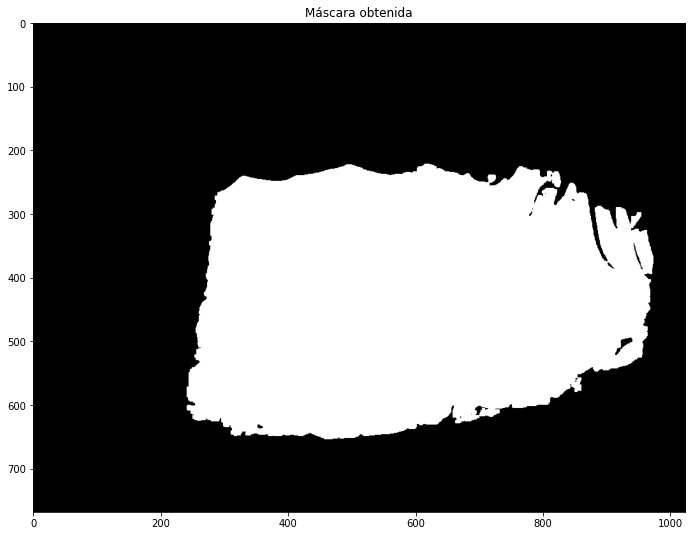

In [11]:
im_04_1_rgb = cv2.cvtColor(im_04_1o, cv2.COLOR_BGR2RGB)

im_04_1_r = im_04_1_rgb[:,:,0]
im_04_1_v = im_04_1_rgb[:,:,1]

plt.rcParams["figure.figsize"] = [12,9] 

# 1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido:
thr, dstOTSU = cv2.threshold(im_04_1_v,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
thr, dst31 = cv2.threshold(dstOTSU, 100, 255, cv2.THRESH_TOZERO) 
dst3_04_1 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))

# 2. Extracción del mayor área en la imagen resultante de la etapa anterior con scikit-image:
labels_mask = measure.label(dst3_04_1)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask_04_1 = labels_mask

# Visualización de la máscara obtenida:
plt.imshow(mask_04_1, cmap='gray')
plt.title('Máscara obtenida')
plt.show()

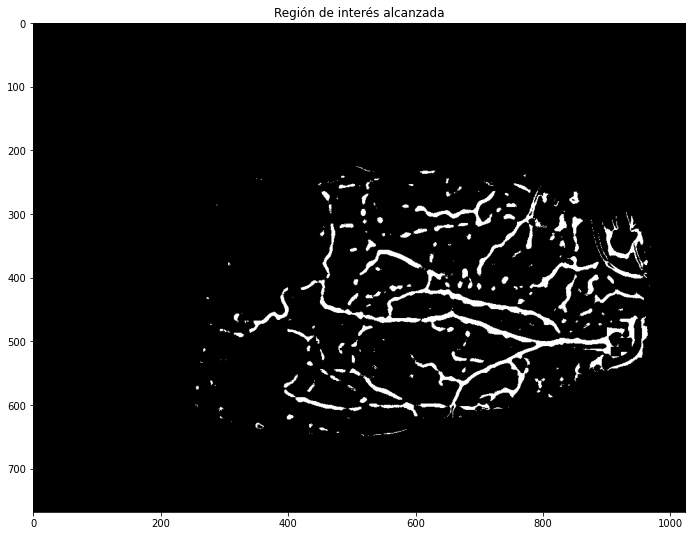

In [12]:
# 3. Filtro de medianas sobre canal G con tamaño 7:
median = cv2.medianBlur(im_04_1_v, 7)

# 4. Aplicación de umbralización adaptativa en canal G para la segmentación y tratar la diferente luminosidad en las imágenes:
adaptThr = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 5. Aplicación de bottom hat de cara a la toma de la métrica:
kernel = np.ones((15,15), np.uint8)
bottom = cv2.morphologyEx(adaptThr, cv2.MORPH_BLACKHAT, kernel)

# 6. Producto del resultado de umbralización adaptativa por el de la máscara generada:
región_final_04_1 = bottom * mask_04_1

plt.imshow(región_final_04_1, cmap='gray')
plt.title('Región de interés alcanzada')
plt.show()

In [13]:
# 1.) Se hace umbralización adaptativa sobre la máscara y la región final:

mask_binary = mask_04_1.astype(np.uint8)
región_final = región_final_04_1.astype(np.uint8)

mask_binary = cv2.adaptiveThreshold(mask_binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
región_final_binary = cv2.adaptiveThreshold(región_final, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 2.) Se efectúa el recuento de los píxeles blancos en la máscara y la región de interés alcanzada:
pixeles_blancos = np.sum(región_final == 255)
print(pixeles_blancos)

pixeles_blancos_mask = np.sum(mask_binary == 255)
print(pixeles_blancos_mask)

# 3.) Planteamiento del biomarcador establecido:
métrica_final_04_1 = (pixeles_blancos/ pixeles_blancos_mask)*100
print(métrica_final_04_1)

27494
786432
3.4960428873697915


## BT_13_2

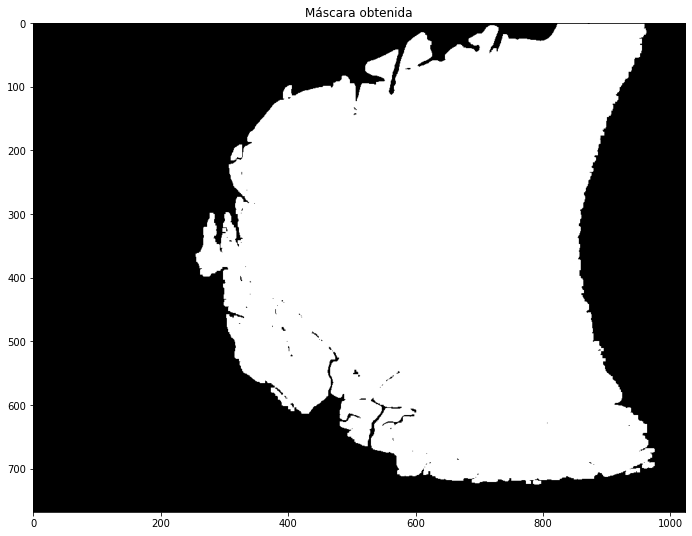

In [14]:
im_13_2_rgb = cv2.cvtColor(im_13_2o, cv2.COLOR_BGR2RGB) 

im_13_2_r = im_13_2_rgb[:,:,0]
im_13_2_v = im_13_2_rgb[:,:,1]
plt.rcParams["figure.figsize"] = [12,9]

# 1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido:
thr, dstOTSU = cv2.threshold(im_13_2_v,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
thr, dst31 = cv2.threshold(dstOTSU, 100, 255, cv2.THRESH_TOZERO) 
dst3_13_2 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))

# 2. Extracción del mayor área en la imagen resultante de la etapa anterior con scikit-image:
labels_mask = measure.label(dst3_13_2)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask_13_2 = labels_mask

# Visualización de la máscara obtenida:
plt.imshow(mask_13_2, cmap='gray')
plt.title('Máscara obtenida')
plt.show()

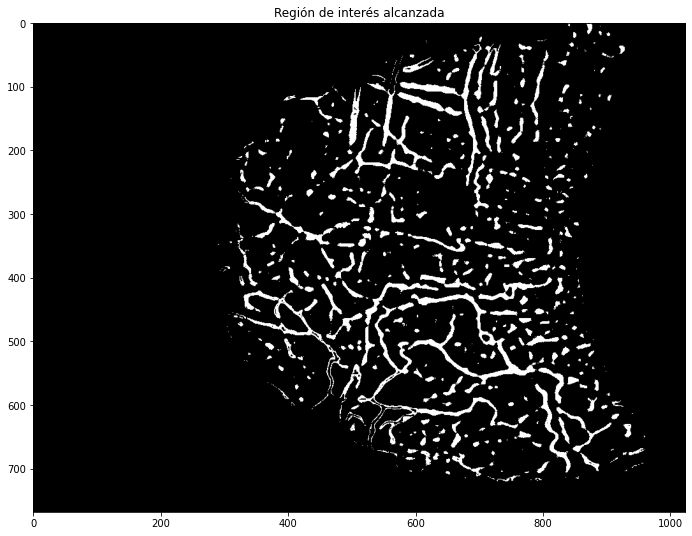

In [15]:
# 3. Filtro de medianas sobre canal G con tamaño 7:
median = cv2.medianBlur(im_13_2_v, 7)

# 4. Aplicación de umbralización adaptativa en canal G para la segmentación y tratar la diferente luminosidad en las imágenes:
adaptThr = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 5. Aplicación de bottom hat de cara a la toma de la métrica:
kernel = np.ones((15,15), np.uint8)
bottom = cv2.morphologyEx(adaptThr, cv2.MORPH_BLACKHAT, kernel)

# 6. Producto del resultado de umbralización adaptativa por el de la máscara generada:
región_final_13_2 = bottom * mask_13_2

plt.imshow(región_final_13_2, cmap='gray')
plt.title('Región de interés alcanzada')
plt.show()

In [16]:
# 1.) Se hace umbralización adaptativa sobre la máscara y la región final:

mask_binary = mask_13_2.astype(np.uint8)
región_final = región_final_13_2.astype(np.uint8)

mask_binary = cv2.adaptiveThreshold(mask_binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
región_final_binary = cv2.adaptiveThreshold(región_final, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 2.) Se efectúa el recuento de los píxeles blancos en la máscara y la región de interés alcanzada:
pixeles_blancos = np.sum(región_final == 255)
print(pixeles_blancos)

pixeles_blancos_mask = np.sum(mask_binary == 255)
print(pixeles_blancos_mask)

# 3.) Planteamiento del biomarcador establecido:
métrica_final_13_2 = (pixeles_blancos/ pixeles_blancos_mask)*100
print(métrica_final_13_2)

46820
786432
5.953470865885416


## BN_15_1

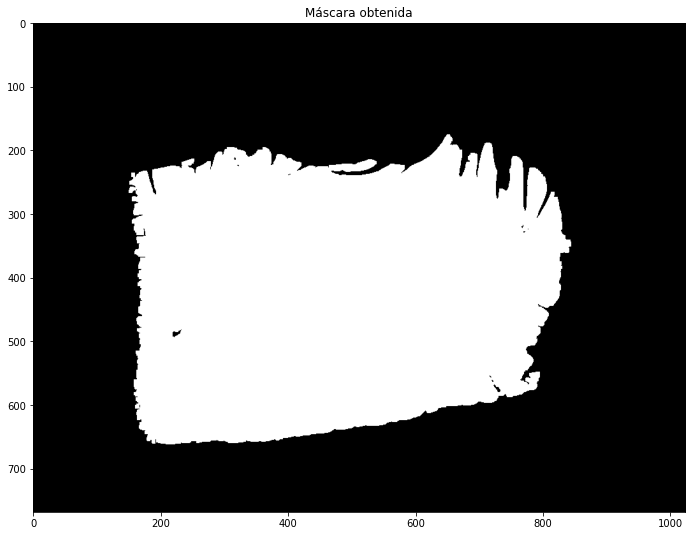

In [17]:
im_15_1_rgb = cv2.cvtColor(im_15_1o, cv2.COLOR_BGR2RGB) 

im_15_1_r = im_15_1_rgb[:,:,0]
im_15_1_v = im_15_1_rgb[:,:,1]

plt.rcParams["figure.figsize"] = [12,9]

# 1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido:
thr, dstOTSU = cv2.threshold(im_15_1_v,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
thr, dst31 = cv2.threshold(dstOTSU, 100, 255, cv2.THRESH_TOZERO) 
dst3_15_1 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))

# 2. Extracción del mayor área en la imagen resultante de la etapa anterior con scikit-image:
labels_mask = measure.label(dst3_15_1)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask_15_1 = labels_mask

# Visualización de la máscara obtenida:
plt.imshow(mask_15_1, cmap='gray')
plt.title('Máscara obtenida')
plt.show()

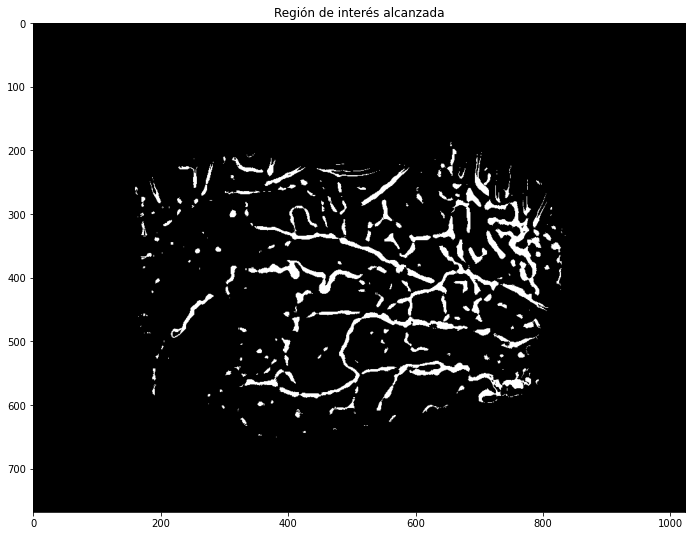

In [18]:
# 3. Filtro de medianas sobre canal G con tamaño 7:
median = cv2.medianBlur(im_15_1_v, 7)

# 4. Aplicación de umbralización adaptativa en canal G para la segmentación y tratar la diferente luminosidad en las imágenes:
adaptThr = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 5. Aplicación de bottom hat de cara a la toma de la métrica:
kernel = np.ones((15,15), np.uint8)
bottom = cv2.morphologyEx(adaptThr, cv2.MORPH_BLACKHAT, kernel)

# 6. Producto del resultado de umbralización adaptativa por el de la máscara generada:
región_final_15_1 = bottom * mask_15_1

plt.imshow(región_final_15_1, cmap='gray')
plt.title('Región de interés alcanzada')
plt.show()

In [19]:
# 1.) Se hace umbralización adaptativa sobre la máscara y la región final:

mask_binary = mask_15_1.astype(np.uint8)
región_final = región_final_15_1.astype(np.uint8)

mask_binary = cv2.adaptiveThreshold(mask_binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
región_final_binary = cv2.adaptiveThreshold(región_final, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 2.) Se efectúa el recuento de los píxeles blancos en la máscara y la región de interés alcanzada:
pixeles_blancos = np.sum(región_final == 255)
print(pixeles_blancos)

pixeles_blancos_mask = np.sum(mask_binary == 255)
print(pixeles_blancos_mask)

# 3.) Planteamiento del biomarcador establecido:
métrica_final_15_1 = (pixeles_blancos/ pixeles_blancos_mask)*100
print(métrica_final_15_1)

30704
786432
3.9042154947916665


## BN_19_1

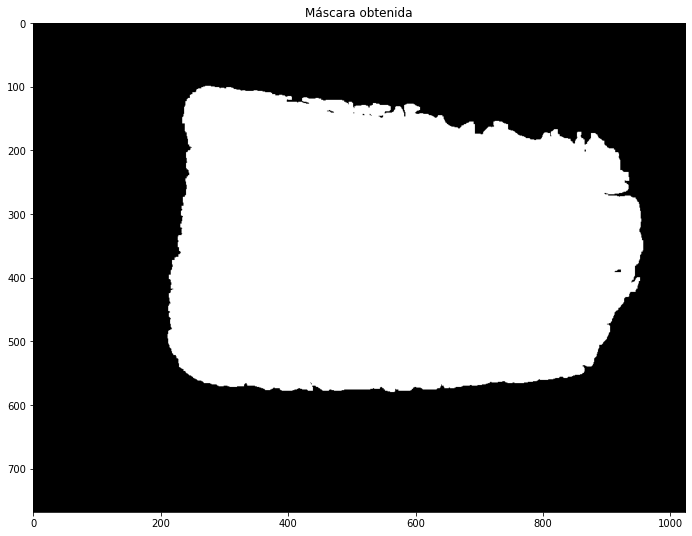

In [20]:
im_19_1_rgb = cv2.cvtColor(im_19_1o, cv2.COLOR_BGR2RGB) 

im_19_1_r = im_19_1_rgb[:,:,0]
im_19_1_v = im_19_1_rgb[:,:,1]

plt.rcParams["figure.figsize"] = [12,9]

# 1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido:
thr, dstOTSU = cv2.threshold(im_19_1_v,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
thr, dst31 = cv2.threshold(dstOTSU, 100, 255, cv2.THRESH_TOZERO) 
dst3_19_1 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))

# 2. Extracción del mayor área en la imagen resultante de la etapa anterior con scikit-image:
labels_mask = measure.label(dst3_19_1)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask_19_1 = labels_mask

# Visualización de la máscara obtenida:
plt.imshow(mask_19_1, cmap='gray')
plt.title('Máscara obtenida')
plt.show()


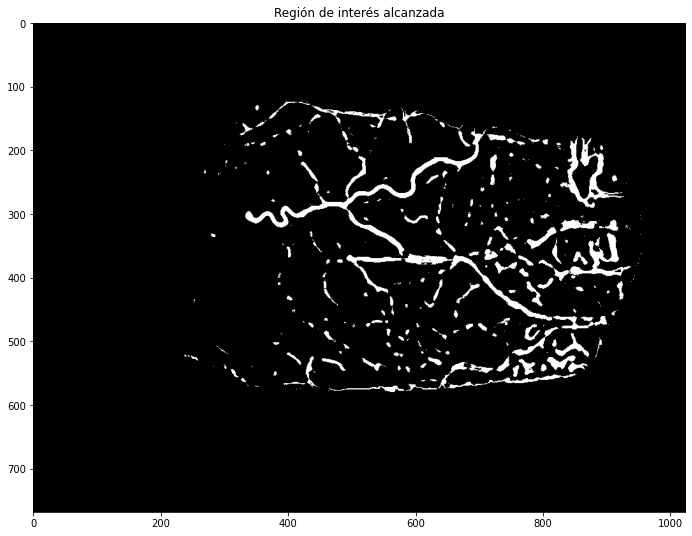

In [21]:
# 3. Filtro de medianas sobre canal G con tamaño 7:
median = cv2.medianBlur(im_19_1_v, 7)

# 4. Aplicación de umbralización adaptativa en canal G para la segmentación y tratar la diferente luminosidad en las imágenes:
adaptThr = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 5. Aplicación de bottom hat de cara a la toma de la métrica:
kernel = np.ones((15,15), np.uint8)
bottom = cv2.morphologyEx(adaptThr, cv2.MORPH_BLACKHAT, kernel)

# 6. Producto del resultado de umbralización adaptativa por el de la máscara generada:
región_final_19_1 = bottom * mask_19_1

plt.imshow(región_final_19_1, cmap='gray')
plt.title('Región de interés alcanzada')
plt.show()

In [22]:
# 1.) Se hace umbralización adaptativa sobre la máscara y la región final:

mask_binary = mask_19_1.astype(np.uint8)
región_final = región_final_19_1.astype(np.uint8)

mask_binary = cv2.adaptiveThreshold(mask_binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
región_final_binary = cv2.adaptiveThreshold(región_final, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 2.) Se efectúa el recuento de los píxeles blancos en la máscara y la región de interés alcanzada:
pixeles_blancos = np.sum(región_final == 255)
print(pixeles_blancos)

pixeles_blancos_mask = np.sum(mask_binary == 255)
print(pixeles_blancos_mask)

# 3.) Planteamiento del biomarcador establecido:
métrica_final_19_1 = (pixeles_blancos/ pixeles_blancos_mask)*100
print(métrica_final_19_1)

29607
786432
3.7647247314453125


## BN_024_1.1

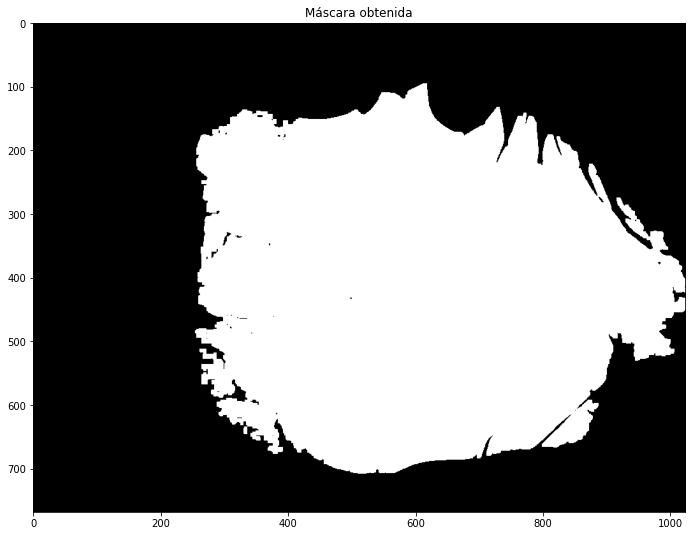

In [23]:
im_24_11_rgb = cv2.cvtColor(im_024_1o, cv2.COLOR_BGR2RGB) 

im_24_11_r = im_24_11_rgb[:,:,0]
im_24_11_v = im_24_11_rgb[:,:,1]

plt.rcParams["figure.figsize"] = [12,9]

# 1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido:
thr, dstOTSU = cv2.threshold(im_24_11_v,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
thr, dst31 = cv2.threshold(dstOTSU, 100, 255, cv2.THRESH_TOZERO) 
dst3_24_11 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))

# 2. Extracción del mayor área en la imagen resultante de la etapa anterior con scikit-image:
labels_mask = measure.label(dst3_24_11)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask_24_11 = labels_mask

# Visualización de la máscara obtenida:
plt.imshow(mask_24_11, cmap='gray')
plt.title('Máscara obtenida')
plt.show()

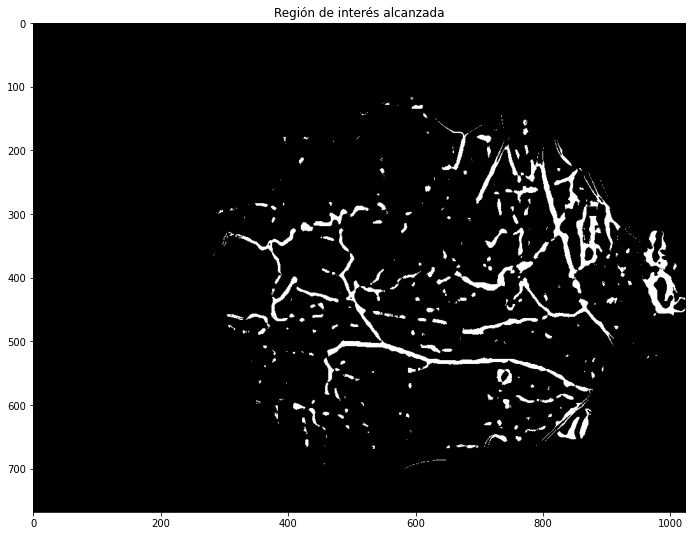

In [24]:
# 3. Filtro de medianas sobre canal G con tamaño 7:
median = cv2.medianBlur(im_24_11_v, 7)

# 4. Aplicación de umbralización adaptativa en canal G para la segmentación y tratar la diferente luminosidad en las imágenes:
adaptThr = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 5. Aplicación de bottom hat de cara a la toma de la métrica:
kernel = np.ones((15,15), np.uint8)
bottom = cv2.morphologyEx(adaptThr, cv2.MORPH_BLACKHAT, kernel)

# 6. Producto del resultado de umbralización adaptativa por el de la máscara generada:
región_final_24_11 = bottom * mask_24_11

plt.imshow(región_final_24_11, cmap='gray')
plt.title('Región de interés alcanzada')
plt.show()

In [25]:
# 1.) Se hace umbralización adaptativa sobre la máscara y la región final:

mask_binary = mask_24_11.astype(np.uint8)
región_final = región_final_24_11.astype(np.uint8)

mask_binary = cv2.adaptiveThreshold(mask_binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
región_final_binary = cv2.adaptiveThreshold(región_final, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 2.) Se efectúa el recuento de los píxeles blancos en la máscara y la región de interés alcanzada:
pixeles_blancos = np.sum(región_final == 255)
print(pixeles_blancos)

pixeles_blancos_mask = np.sum(mask_binary == 255)
print(pixeles_blancos_mask)

# 3.) Planteamiento del biomarcador establecido:
métrica_final_24_11 = (pixeles_blancos/ pixeles_blancos_mask)*100
print(métrica_final_24_11)

29988
786432
3.81317138671875


## BN_056_3

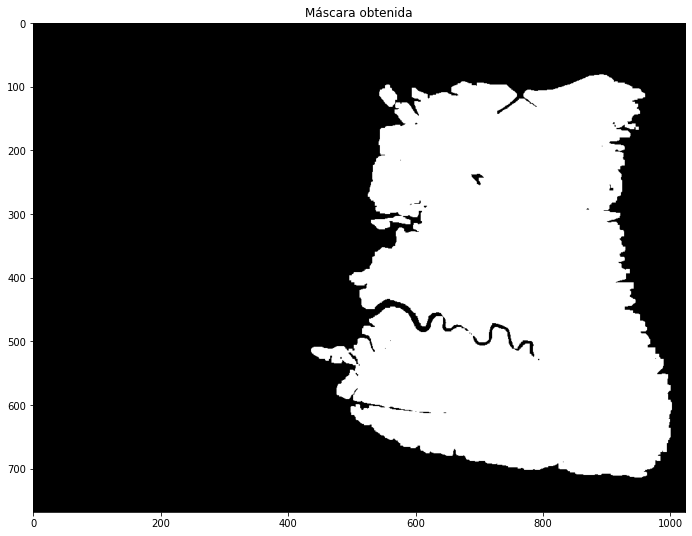

In [26]:
im_56_3_rgb = cv2.cvtColor(im_056_3o, cv2.COLOR_BGR2RGB) 

im_56_3_r = im_56_3_rgb[:,:,0]
im_56_3_v = im_56_3_rgb[:,:,1]

plt.rcParams["figure.figsize"] = [12,9]

# 1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido:
thr, dstOTSU = cv2.threshold(im_56_3_v,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
thr, dst31 = cv2.threshold(dstOTSU, 100, 255, cv2.THRESH_TOZERO) 
dst3_56_3 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))

# 2. Extracción del mayor área en la imagen resultante de la etapa anterior con scikit-image:
labels_mask = measure.label(dst3_56_3)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask_56_3 = labels_mask

# Visualización de la máscara obtenida:
plt.imshow(mask_56_3, cmap='gray')
plt.title('Máscara obtenida')
plt.show()


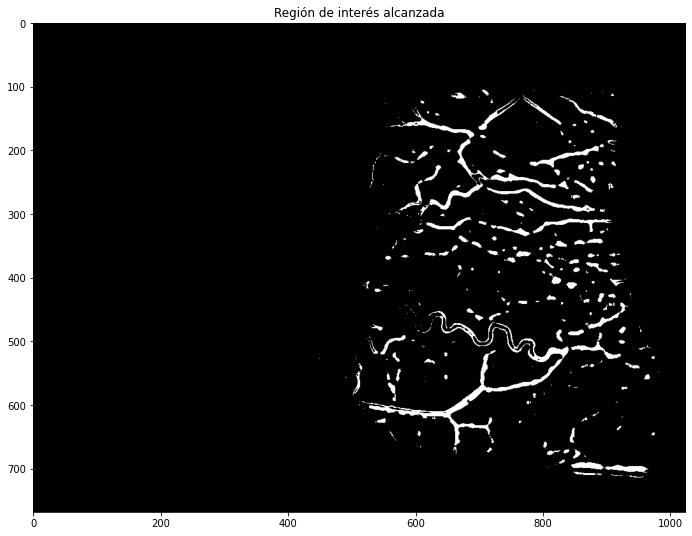

In [27]:
# 3. Filtro de medianas sobre canal G con tamaño 7:
median = cv2.medianBlur(im_56_3_v, 7)

# 4. Aplicación de umbralización adaptativa en canal G para la segmentación y tratar la diferente luminosidad en las imágenes:
adaptThr = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 5. Aplicación de bottom hat de cara a la toma de la métrica:
kernel = np.ones((15,15), np.uint8)
bottom = cv2.morphologyEx(adaptThr, cv2.MORPH_BLACKHAT, kernel)

# 6. Producto del resultado de umbralización adaptativa por el de la máscara generada:
región_final_56_3 = bottom * mask_56_3

plt.imshow(región_final_56_3, cmap='gray')
plt.title('Región de interés alcanzada')
plt.show()

In [28]:
# 1.) Se hace umbralización adaptativa sobre la máscara y la región final:

mask_binary = mask_56_3.astype(np.uint8)
región_final = región_final_56_3.astype(np.uint8)

mask_binary = cv2.adaptiveThreshold(mask_binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
región_final_binary = cv2.adaptiveThreshold(región_final, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 2.) Se efectúa el recuento de los píxeles blancos en la máscara y la región de interés alcanzada:
pixeles_blancos = np.sum(región_final == 255)
print(pixeles_blancos)

pixeles_blancos_mask = np.sum(mask_binary == 255)
print(pixeles_blancos_mask)

# 3.) Planteamiento del biomarcador establecido:
métrica_final_56_3 = (pixeles_blancos/ pixeles_blancos_mask)*100
print(métrica_final_56_3)

21725
786432
2.7624766031901045


#### Se puede que en este caso, la imagen BN_056_3 no presenta unas medidas que coincidan con lo esperado. Esto se podría asociar fundamentalmente a que la extracción de la región de interés resulta más difícil, pues hay una luminosidad muy reducida y diferencia notable en contraste.

## BN_058_2

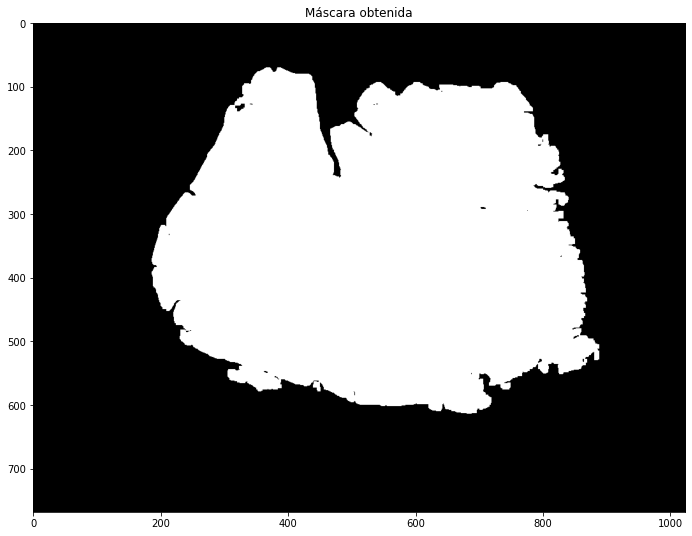

In [29]:
im_58_2_rgb = cv2.cvtColor(im_058_2o, cv2.COLOR_BGR2RGB) 

im_58_2_r = im_58_2_rgb[:,:,0]
im_58_2_v = im_58_2_rgb[:,:,1]

plt.rcParams["figure.figsize"] = [12,9]

# 1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido:
thr, dstOTSU = cv2.threshold(im_58_2_v,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
thr, dst31 = cv2.threshold(dstOTSU, 100, 255, cv2.THRESH_TOZERO) 
dst3_58_2 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))

# 2. Extracción del mayor área en la imagen resultante de la etapa anterior con scikit-image:
labels_mask = measure.label(dst3_58_2)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask_58_2 = labels_mask

# Visualización de la máscara obtenida:
plt.imshow(mask_58_2, cmap='gray')
plt.title('Máscara obtenida')
plt.show()

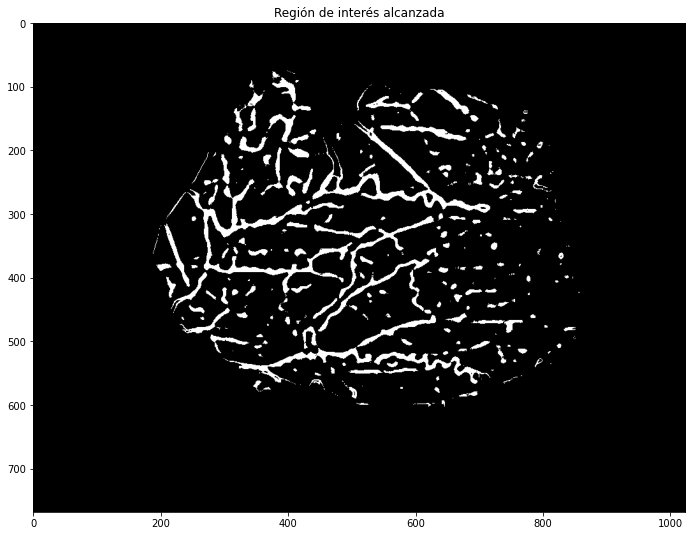

In [30]:
# 3. Filtro de medianas sobre canal G con tamaño 7:
median = cv2.medianBlur(im_58_2_v, 7)

# 4. Aplicación de umbralización adaptativa en canal G para la segmentación y tratar la diferente luminosidad en las imágenes:
adaptThr = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 5. Aplicación de bottom hat de cara a la toma de la métrica:
kernel = np.ones((15,15), np.uint8)
bottom = cv2.morphologyEx(adaptThr, cv2.MORPH_BLACKHAT, kernel)

# 6. Producto del resultado de umbralización adaptativa por el de la máscara generada:
región_final_58_2 = bottom * mask_58_2

plt.imshow(región_final_58_2, cmap='gray')
plt.title('Región de interés alcanzada')
plt.show()

In [31]:
# 1.) Se hace umbralización adaptativa sobre la máscara y la región final:

mask_binary = mask_58_2.astype(np.uint8)
región_final = región_final_58_2.astype(np.uint8)

mask_binary = cv2.adaptiveThreshold(mask_binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
región_final_binary = cv2.adaptiveThreshold(región_final, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 2.) Se efectúa el recuento de los píxeles blancos en la máscara y la región de interés alcanzada:
pixeles_blancos = np.sum(región_final == 255)
print(pixeles_blancos)

pixeles_blancos_mask = np.sum(mask_binary == 255)
print(pixeles_blancos_mask)

# 3.) Planteamiento del biomarcador establecido:
métrica_final_58_2 = (pixeles_blancos/ pixeles_blancos_mask)*100
print(métrica_final_58_2)

38810
786432
4.934946695963541


## BT_12_2.5

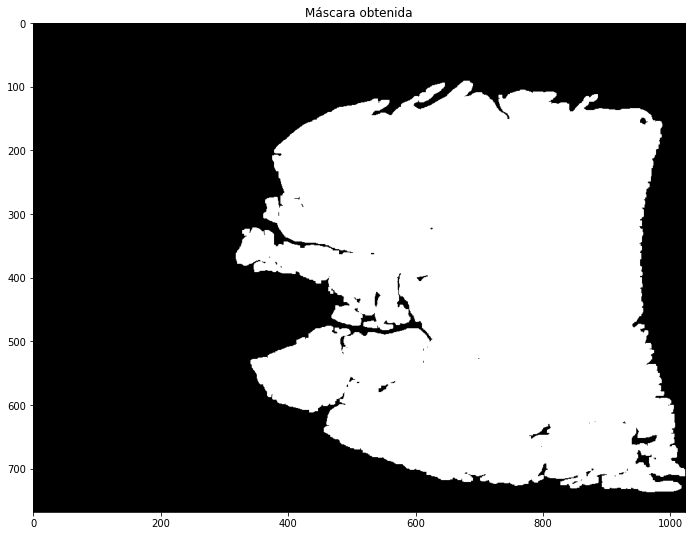

In [32]:
im_t12_25_rgb = cv2.cvtColor(im_t12_25o, cv2.COLOR_BGR2RGB) 

im_t12_25_r = im_t12_25_rgb[:,:,0]
im_t12_25_v = im_t12_25_rgb[:,:,1]

plt.rcParams["figure.figsize"] = [12,9]

# 1. Umbralización Otsu y thres_tozero, con posterior apertura para eliminación de ruido:
thr, dstOTSU = cv2.threshold(im_t12_25_v,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
thr, dst31 = cv2.threshold(dstOTSU, 100, 255, cv2.THRESH_TOZERO) 
dst3_t12_25 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))

# 2. Extracción del mayor área en la imagen resultante de la etapa anterior con scikit-image:
labels_mask = measure.label(dst3_t12_25)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask_t12_25 = labels_mask

# Visualización de la máscara obtenida:
plt.imshow(mask_t12_25, cmap='gray')
plt.title('Máscara obtenida')
plt.show()

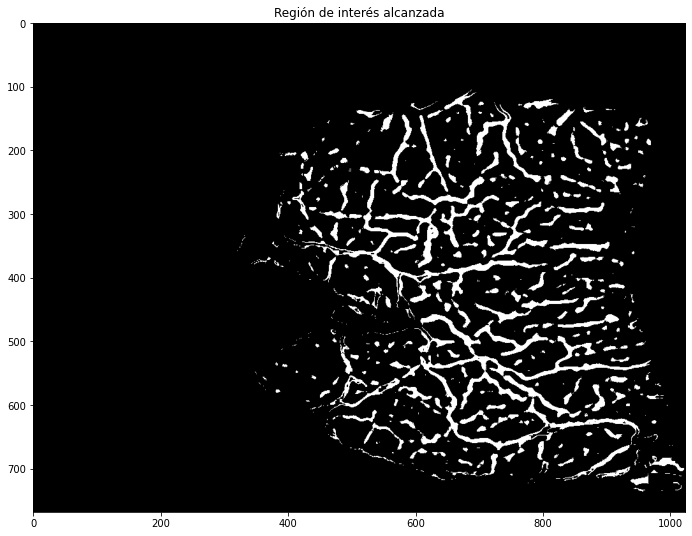

In [33]:
# 3. Filtro de medianas sobre canal G con tamaño 7:
median = cv2.medianBlur(im_t12_25_v, 7)

# 4. Aplicación de umbralización adaptativa en canal G para la segmentación y tratar la diferente luminosidad en las imágenes:
adaptThr = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 5. Aplicación de bottom hat de cara a la toma de la métrica:
kernel = np.ones((15,15), np.uint8)
bottom = cv2.morphologyEx(adaptThr, cv2.MORPH_BLACKHAT, kernel)

# 6. Producto del resultado de umbralización adaptativa por el de la máscara generada:
región_final_t12_25 = bottom * mask_t12_25

plt.imshow(región_final_t12_25, cmap='gray')
plt.title('Región de interés alcanzada')
plt.show()

In [34]:
# 1.) Se hace umbralización adaptativa sobre la máscara y la región final:

mask_binary = mask_t12_25.astype(np.uint8)
región_final = región_final_t12_25.astype(np.uint8)

mask_binary = cv2.adaptiveThreshold(mask_binary, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
región_final_binary = cv2.adaptiveThreshold(región_final, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# 2.) Se efectúa el recuento de los píxeles blancos en la máscara y la región de interés alcanzada:
pixeles_blancos = np.sum(región_final == 255)
print(pixeles_blancos)

pixeles_blancos_mask = np.sum(mask_binary == 255)
print(pixeles_blancos_mask)

# 3.) Planteamiento del biomarcador establecido:
métrica_final_t12_25 = (pixeles_blancos/ pixeles_blancos_mask)*100
print(métrica_final_t12_25)

51151
786432
6.5041859944661455


# RESULTADOS Y DISCUSIÓN.

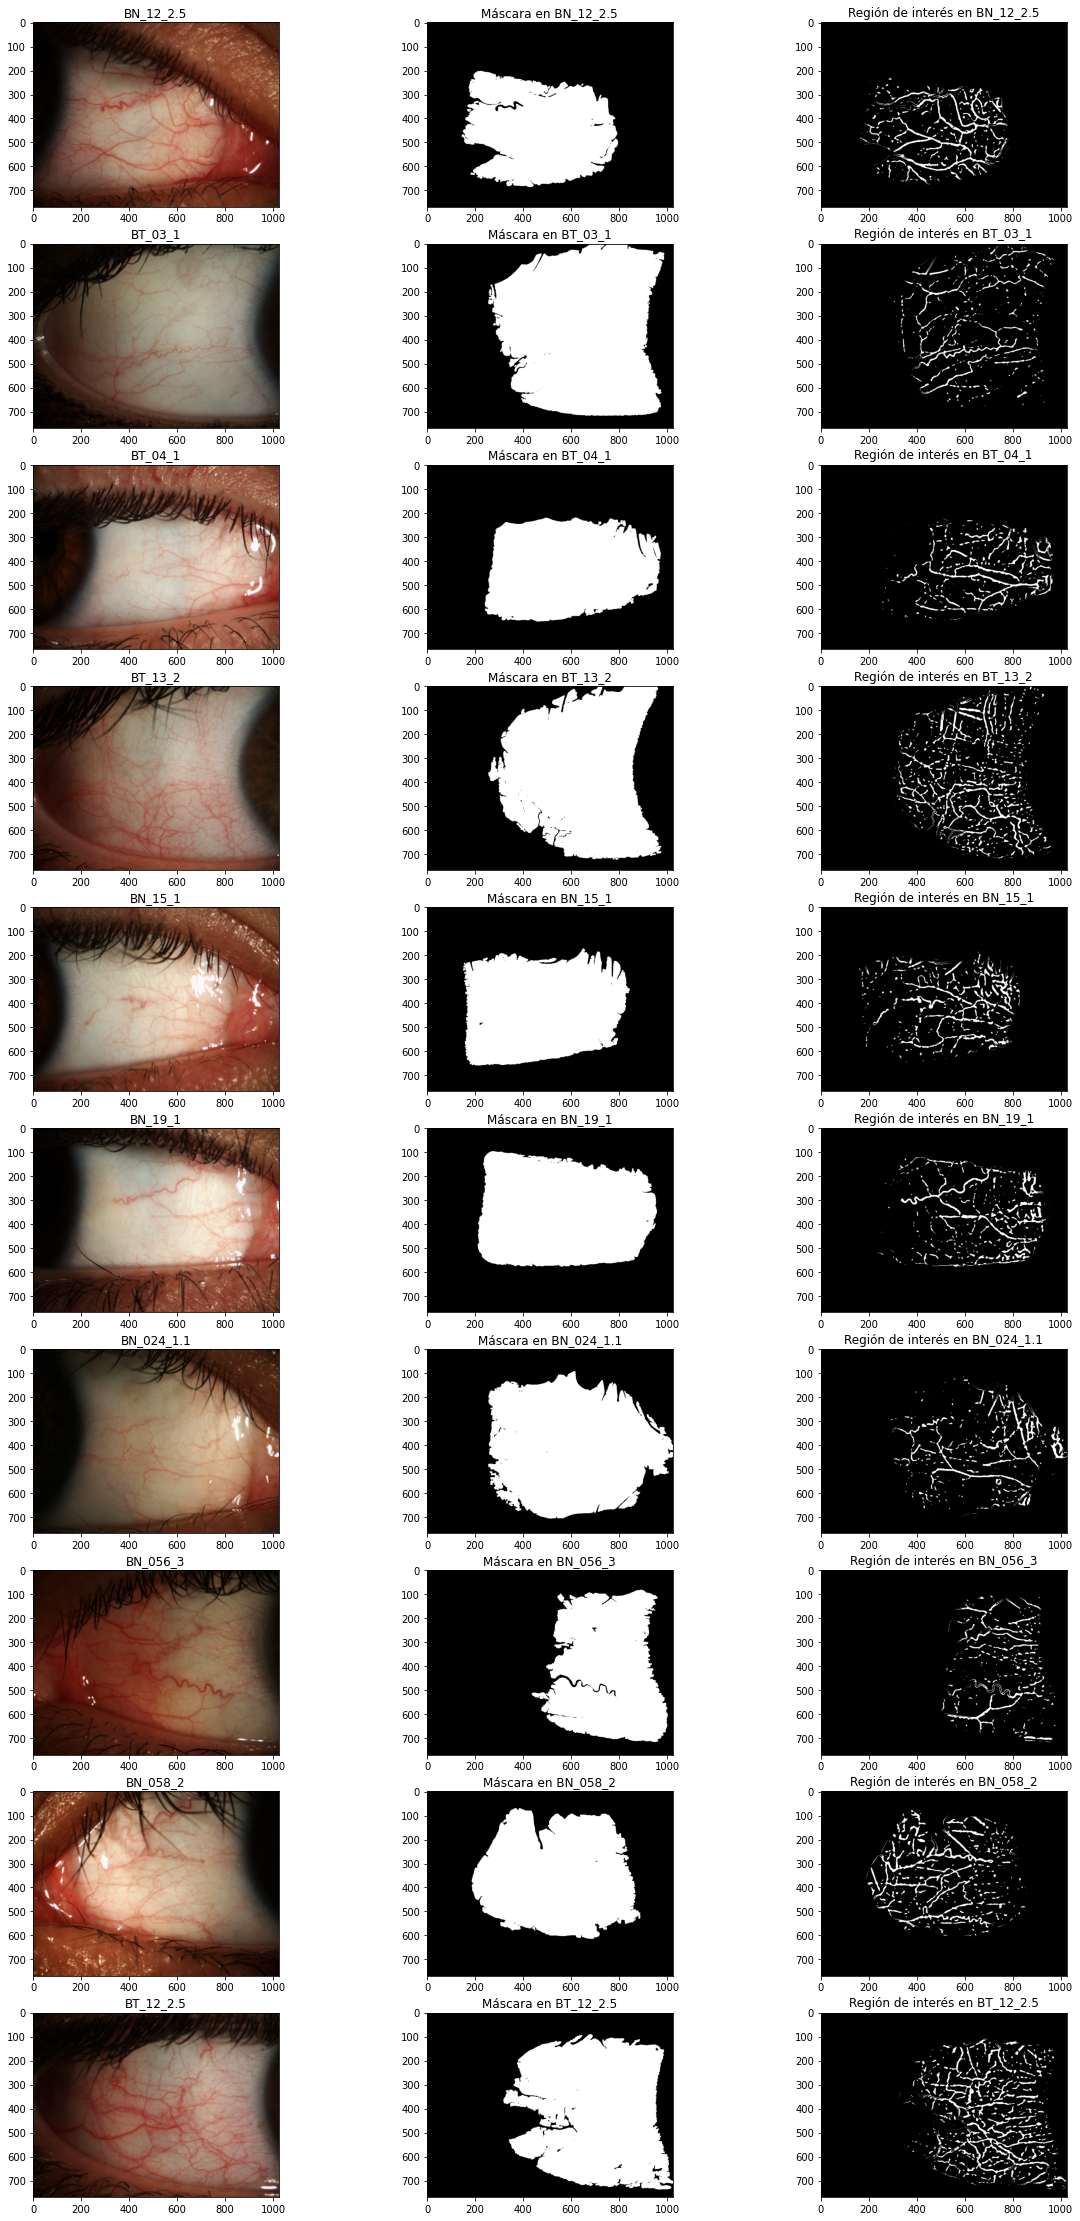

In [35]:
# Recopilación de los resultados alcanzados en la máscara y región de interés para las imágenes:
plt.rcParams["figure.figsize"] = [20,40]
f, axarr = plt.subplots(10,3)
axarr[0,0].imshow(im_12_25_rgb, cmap='gray')
axarr[0,0].set_title('BN_12_2.5')
axarr[0,1].imshow(mask_12_25, cmap='gray')
axarr[0,1].set_title('Máscara en BN_12_2.5')
axarr[0,2].imshow(región_final_12_25, cmap='gray')
axarr[0,2].set_title('Región de interés en BN_12_2.5')
axarr[1,0].imshow(im_03_1_rgb, cmap='gray')
axarr[1,0].set_title('BT_03_1')
axarr[1,1].imshow(mask_03_1, cmap='gray')
axarr[1,1].set_title('Máscara en BT_03_1')
axarr[1,2].imshow(región_final_03_1, cmap='gray')
axarr[1,2].set_title('Región de interés en BT_03_1')
axarr[2,0].imshow(im_04_1_rgb, cmap='gray')
axarr[2,0].set_title('BT_04_1')
axarr[2,1].imshow(mask_04_1, cmap='gray')
axarr[2,1].set_title('Máscara en BT_04_1')
axarr[2,2].imshow(región_final_04_1, cmap='gray')
axarr[2,2].set_title('Región de interés en BT_04_1')
axarr[3,0].imshow(im_13_2_rgb, cmap='gray')
axarr[3,0].set_title('BT_13_2')
axarr[3,1].imshow(mask_13_2, cmap='gray')
axarr[3,1].set_title('Máscara en BT_13_2')
axarr[3,2].imshow(región_final_13_2, cmap='gray')
axarr[3,2].set_title('Región de interés en BT_13_2')
axarr[4,0].imshow(im_15_1_rgb, cmap='gray')
axarr[4,0].set_title('BN_15_1')
axarr[4,1].imshow(mask_15_1, cmap='gray')
axarr[4,1].set_title('Máscara en BN_15_1')
axarr[4,2].imshow(región_final_15_1, cmap='gray')
axarr[4,2].set_title('Región de interés en BN_15_1')
axarr[5,0].imshow(im_19_1_rgb, cmap='gray')
axarr[5,0].set_title('BN_19_1')
axarr[5,1].imshow(mask_19_1, cmap='gray')
axarr[5,1].set_title('Máscara en BN_19_1')
axarr[5,2].imshow(región_final_19_1, cmap='gray')
axarr[5,2].set_title('Región de interés en BN_19_1')
axarr[6,0].imshow(im_24_11_rgb, cmap='gray')
axarr[6,0].set_title('BN_024_1.1')
axarr[6,1].imshow(mask_24_11, cmap='gray')
axarr[6,1].set_title('Máscara en BN_024_1.1')
axarr[6,2].imshow(región_final_24_11, cmap='gray')
axarr[6,2].set_title('Región de interés en BN_024_1.1')
axarr[7,0].imshow(im_56_3_rgb, cmap='gray') 
axarr[7,0].set_title('BN_056_3') 
axarr[7,1].imshow(mask_56_3, cmap='gray') 
axarr[7,1].set_title('Máscara en BN_056_3')
axarr[7,2].imshow(región_final_56_3, cmap='gray')
axarr[7,2].set_title('Región de interés en BN_056_3')
axarr[8,0].imshow(im_58_2_rgb, cmap='gray') 
axarr[8,0].set_title('BN_058_2') 
axarr[8,1].imshow(mask_58_2, cmap='gray') 
axarr[8,1].set_title('Máscara en BN_058_2')
axarr[8,2].imshow(región_final_58_2, cmap='gray')
axarr[8,2].set_title('Región de interés en BN_058_2')
axarr[9,0].imshow(im_t12_25_rgb, cmap='gray') 
axarr[9,0].set_title('BT_12_2.5') 
axarr[9,1].imshow(mask_t12_25, cmap='gray') 
axarr[9,1].set_title('Máscara en BT_12_2.5')
axarr[9,2].imshow(región_final_t12_25, cmap='gray')
axarr[9,2].set_title('Región de interés en BT_12_2.5')
plt.show()

#### A continuación, se muestran los resultados para la métrica planteada en cada una de las imágenes:

|  **Imagen** | **Biomarcador** |
|:-----------:|:---------------:|
|   BT_04_1   |       3.50      |
|  BN_024_1.1 |       3.81      |
|   BN_15_1   |       3.90      |
|   BN_056_3  |       **2.76**      |
|   BN_058_2  |       4.93      |
|  BN_12_2.5  |       4.10      |
|   BT_03_1   |       3.43      |
|   BN_19_1   |       3.76      |
|   BT_13_2   |       5.95      |
|  BT_12_2.5  |       6.50      |

#### En general, se puede observar una tendencia de incremento en los valores de la métrica conforme lo hace el grado de hiperemia que se observa en las imágenes originales del dataset. Cabe destacar que con la imagen BN_056_3, la dificultad de extraer adecuadamente la máscara implica que esta es más reducida en dimensiones, de ahí la anomalía en el resultado logrado. 

#### Por tanto, si comparamos los resultados de esta metodología con los de la referencia del enunciado, podemos establecer los siguientes rangos, que permiten una clasificación del grado de hiperemia conjuntival ante nuevas imágenes de pacientes:

| Clasificación Especialista | Clasificación Especialista | Clasificación Metodología |
|:--------------------------:|:--------------------------:|:-------------------------:|
|           1 – 1.5          |           0 – 3.9          |         Nivel bajo        |
|          1.5 – 2.5         |         3.9 – 4.9          |        Nivel medio        |
|            2.5-3           |          4.9 – 6.5         |         Nivel alto        |

#### El nivel bajo hace referencia a una conjuntiva bulbar con vasos de dimensiones reducidas, de modo que está presenta claridad de forma predominante. Con respecto al nivel medio, hay una tendencia de incremento en el enrojecimiento, con vasos que presentan mayores dimensiones y se localizan concentrados en algunas regiones. Este último factor, junto con el incremento en las dimensiones, es la clave en la transición del nivel medio al nivel alto, donde el nivel de enrojecimiento es notablemente marcado.

# CONCLUSIONES.

#### En esta práctica se presenta una metodología dedicada a la extracción de la conjuntiva bulbar y determinación de la ocupación de vasos en la misma por medio de una métrica. Los resultados obtenidos muestran que, con excepción de la imagen BN_056_3, la metodología proporciona una adecuada identificación de la región de interés, reducción de ruido y segmentación de los vasos. De este modo, la métrica propuesta sigue una tendencia que coincide con lo esperado teniendo en cuenta la referencia del enunciado.  Para futuros trabajos, sería necesario mejorar, por un método adicional, aquellos casos como los de la imagen BN_056_3, cuya luminosidad y contraste ha resultado problemática para conseguir la totalidad de resultados adecuados en las imágenes proporcionadas del dataset.